In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

import cv2
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete, EnsureType, Activations
from monai.data import decollate_batch
import monai
from monai.data import Dataset, DataLoader
from monai.transforms import LoadImage, LoadImaged, Compose, ScaleIntensityd, ToTensord, RandRotate90d, RandFlipd, RandScaleIntensityd, RandShiftIntensityd

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from Milesial.unet_model import UNet
working_path = './ACDC'

In [60]:
def load_file_dict(patient_id, mode: str):
    # Determine the folder (training or testing) based on patient_id
    if 1 <= patient_id <= 100:
        folder = 'training'
        patient_folder = f'patient{patient_id:03d}'
    elif 101 <= patient_id <= 150:
        folder = 'testing'
        patient_folder = f'patient{patient_id:03d}'
    else:
        raise ValueError("Patient ID should be between 1-100 for training or 101-150 for testing.")

    # Construct the file paths
    base_path = os.path.join(working_path, folder, patient_folder)
    cfg_file = os.path.join(base_path, 'Info.cfg')

    # Read info.cfg file to get the frame numbers for ED and ES
    with open(cfg_file, 'r') as f:
        cfg_data = f.readlines()

    # Extract frame numbers for ED and ES
    ed_frame, es_frame = None, None
    for line in cfg_data:
        key, value = line.strip().split(': ')
        if key == 'ED':
            ed_frame = int(value)
        elif key == 'ES':
            es_frame = int(value)

    if mode == 'ED':
        frame_number = ed_frame
        image_file = os.path.join(base_path, f'{patient_folder}_frame01.nii.gz')
        segmentation_file = os.path.join(base_path, f'{patient_folder}_frame01_gt.nii.gz')
    elif mode == 'ES':
        frame_number = es_frame
    else:
        raise ValueError("Mode should be either 'ED' or 'ES'.")
    
    image_file = os.path.join(base_path, f'{patient_folder}_frame{frame_number:02d}.nii.gz')
    segmentation_file = os.path.join(base_path, f'{patient_folder}_frame{frame_number:02d}_gt.nii.gz')

    return {"image": str(image_file), "segmentation": str(segmentation_file)}

def load_data_dict(patient_id, mode: str):
    file_dict = load_file_dict(patient_id, mode)

    # Load the MRI image
    image = LoadImage(image_only=True)(file_dict["image"])

    # Load the segmentation image
    segmentation = LoadImage(image_only=True)(file_dict["segmentation"])
    
    data_dict = {"image": image, "segmentation": segmentation}
    return data_dict

def visualize_patient(mri_slices, seg_slices,title):
    num_slices = mri_slices.shape[2]
    fig, axes = plt.subplots(2, num_slices // 2, figsize=(20, 8))
    fig.suptitle(title, fontsize=20)
    
    # Define a color map for the segmentation overlay
    cmap = ListedColormap([(0, 0, 0, 0), (1, 0, 0, 0.5), (0, 1, 0, 0.5), (0, 0, 1, 0.5)])
    
    for i in range(num_slices):
        row = i // (num_slices // 2)
        col = i % (num_slices // 2)

        axes[row, col].imshow(mri_slices[:, :, i], cmap='gray')
        axes[row, col].imshow(seg_slices[:, :, i], cmap=cmap)
        axes[row, col].set_title(f'Slice {i}')
        axes[row, col].axis('off')
    
    
    plt.tight_layout()
    plt.show()

In [61]:
test_dicts = [load_data_dict(i, 'ED') for i in tqdm(range(101, 151))] + [load_data_dict(i, 'ES') for i in tqdm(range(101, 151))]
print(len(test_dicts))

100%|██████████| 50/50 [00:03<00:00, 14.39it/s]

100


In [62]:
def to_2D_slices(img_dicts):
    new_dicts = []
    for i in tqdm(range(len(img_dicts))): # iterate over all volumes
        for j in range(img_dicts[i]['image'].shape[2]): # iterate over all slices in the volume
            # Store each slice as a separate entry in the new dictionary
            dictionnary = {'image': img_dicts[i]['image'][:, :, j], 'segmentation': img_dicts[i]['segmentation'][:, :, j]}
            new_dicts.append(dictionnary)
    return new_dicts

In [63]:
test_slices_dicts = to_2D_slices(test_dicts)
print(len(test_slices_dicts))

100%|██████████| 100/100 [00:00<00:00, 193.61it/s]

1076


In [ ]:
from skimage.util import view_as_windows
def patch_sampling_and_evaluation(image_dict, segmentation_dict, model_path, patch_size=(64, 64), stride=(32, 32)):
    """
    Perform patch sampling, model prediction, reconstruction of the segmentation map, 
    and evaluation using the Dice coefficient.
    
    Parameters:
        image_dict (dict): Dictionary containing the images.
        segmentation_dict (dict): Dictionary containing the ground truth segmentations.
        model_path (str): Path to the trained model.
        patch_size (tuple): Size of the patches (height, width).
        stride (tuple): Stride for the sliding window (vertical_step, horizontal_step).
        
    Returns:
        dict: Dictionary with Dice scores for each image.
    """
    # Load the trained model
    model = tf.keras.models.load_model(model_path)
    
    dice_scores = {}

    for key in image_dict.keys():
        image = image_dict[key]
        ground_truth = segmentation_dict[key]
        
        # Extract patches
        patches = view_as_windows(image, patch_size + (image.shape[2],), step=stride)
        patches_shape = patches.shape
        patches = patches.reshape(-1, patch_size[0], patch_size[1], image.shape[2])
        
        # Preprocess patches (example normalization, adjust based on your model's needs)
        patches = patches / 255.0
        
        # Predict patches
        predicted_patches = model.predict(patches)
        
        # Reshape predicted patches back to the original image's patch structure
        predicted_patches = predicted_patches.reshape(patches_shape[0], patches_shape[1], patch_size[0], patch_size[1], -1)
        
        # Reconstruct the full segmentation map
        segmentation_map = np.zeros_like(image)
        count_map = np.zeros_like(image, dtype=np.float32)
        
        for i in range(patches_shape[0]):
            for j in range(patches_shape[1]):
                start_i = i * stride[0]
                start_j = j * stride[1]
                segmentation_map[start_i:start_i+patch_size[0], start_j:start_j+patch_size[1]] += predicted_patches[i, j]
                count_map[start_i:start_i+patch_size[0], start_j:start_j+patch_size[1]] += 1
        
        # Average the overlapping regions
        segmentation_map = segmentation_map / count_map
        
        # Binarize the segmentation map (assuming binary segmentation, adjust threshold as needed)
        segmentation_map = (segmentation_map > 0.5).astype(np.float32)
        
        # Calculate Dice coefficient
        dice_score = 2 * np.sum(segmentation_map * ground_truth) / (np.sum(segmentation_map) + np.sum(ground_truth))
        
        # Store Dice score
        dice_scores[key] = dice_score

    return dice_scores

In [78]:
from skimage.util import view_as_windows
def patch_sampler(data_dict, patch_size=(128, 128)):
    image = data_dict['image'].numpy()
    segmentation = data_dict['segmentation'].numpy()
    # Extract patches
    patches_image = view_as_windows(image, patch_size, step=patch_size)
    patches_segmentation = view_as_windows(segmentation, patch_size, step=patch_size)
    
    # Reshape patches
    patches_image = patches_image.reshape(-1, patch_size[0], patch_size[1])
    patches_segmentation = patches_segmentation.reshape(-1, patch_size[0], patch_size[1])
    
    # Return a list of dictionaries containing the patches
    return [{"image": torch.tensor(patches_image[i]), "segmentation": torch.tensor(patches_segmentation[i])} for i in range(patches_image.shape[0])]

In [79]:
# Exemple : 
print(test_slices_dicts[0]["image"])
patches = patch_sampler(test_slices_dicts[0], patch_size=(128, 128))
print(len(patches))

metatensor([[19., 19., 19.,  ..., 19., 19., 19.],
        [19., 19., 26.,  ..., 19., 19., 19.],
        [19., 19., 26.,  ..., 19., 19., 19.],
        ...,
        [19., 19., 19.,  ..., 20., 21., 21.],
        [19., 19., 19.,  ..., 21., 21., 21.],
        [19., 19., 19.,  ..., 19., 19., 19.]])
2


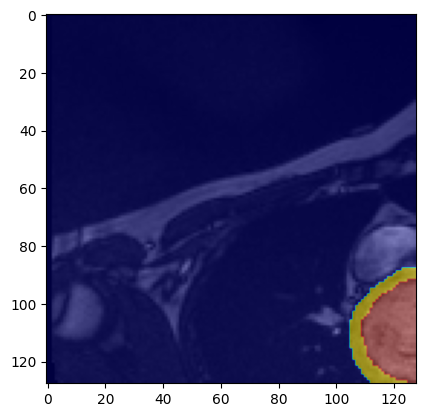

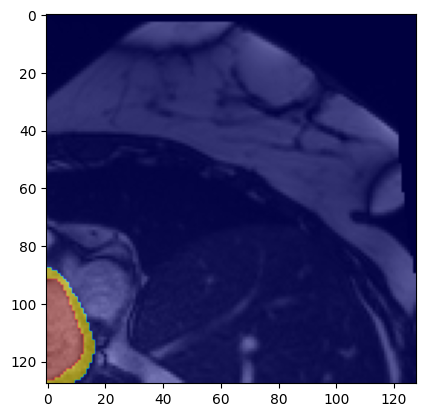

In [82]:
plt.imshow(patches[0]["image"], cmap='gray')
plt.imshow(patches[0]["segmentation"], cmap='jet', alpha=0.5)
plt.show()

plt.imshow(patches[1]["image"], cmap='gray')
plt.imshow(patches[1]["segmentation"], cmap='jet', alpha=0.5)

In [83]:
# Do this for all slices
test_patches = [patch_sampler(d) for d in tqdm(test_slices_dicts)]

100%|██████████| 1076/1076 [00:01<00:00, 640.53it/s]


In [87]:
all_patched = []
for i in range(len(test_patches)):
    all_patched += test_patches[i]

## DataLoader

In [84]:
class SimpleDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        segmentation = item['segmentation']

        # Add channel dimension to the image
        image = image.unsqueeze(0)

        return {'image': image, 'segmentation': segmentation}

## Test :

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
criterion1 = nn.CrossEntropyLoss()
criterion2 = DiceMetric(include_background=False, reduction="mean", get_not_nans=True)


In [94]:
test_dataset = SimpleDataset(data=all_patched)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [96]:
def visualize_batch(batch, batch_size=BATCH_SIZE):
    images, segmentations = batch["image"], batch["segmentation"]
    fig, axes = plt.subplots(2, batch_size//2, figsize=(20, 8))
    fig.suptitle('Batch of MRI + Segmentations', fontsize=20)

    cmap = ListedColormap([(0, 0, 0, 0), (1, 0, 0, 0.5), (0, 1, 0, 0.5), (0, 0, 1, 0.5)])
    for i in range(batch_size):
        row = i // (batch_size // 2)
        col = i % (batch_size // 2)

        images = images.squeeze(1)
        axes[row, col].imshow(images[i, :, :], cmap='gray')
        axes[row, col].imshow(segmentations[i, :, :], cmap=cmap)
        axes[row, col].set_title(f'Slice {i}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Visualize the first batch
batch = next(iter(test_loader))
print(f"Batch of images shape: {batch['image'].shape}")
print(f"Batch of segmentations shape: {batch['segmentation'].shape}")
#visualize_batch(batch)
print(batch['segmentation'].type())

Batch of images shape: torch.Size([16, 1, 128, 128])
Batch of segmentations shape: torch.Size([16, 128, 128])
torch.FloatTensor


In [97]:
# Evaluate the model
metrics = {'CE loss': [], 'dice': []}

def evaluate_model(model, test_loader, criterion1):
    model.eval()
    running_loss_1 = 0.0
    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['image'].to(device)
            segmentations = batch['segmentation'].to(device)
            segmentations = segmentations.long()
            
            # Forward pass
            outputs = model(images)
            outputs = outputs.squeeze(1)
            
            # Compute the loss
            loss_1 = criterion1(outputs, segmentations)

            running_loss_1 += loss_1.item() * images.size(0)

    loss_1 = running_loss_1 / len(test_loader.dataset)
    print(f'Test |CE Loss: {loss_1:.4f}')
    # Save the metrics
    metrics['CE loss'].append(loss_1)


# Evaluate the model
#load the model
model = UNet(n_channels=1, n_classes=4).to(device)
model.load_state_dict(torch.load('./saved_weights/unet_try3.pth'))
evaluate_model(model, test_loader, criterion1)

100%|██████████| 113/113 [11:55<00:00,  6.33s/it]

Test |CE Loss: 0.5098


In [99]:
def evaluate_model_dice(model, test_loader):
    model.eval()
    
    # Initialize the DiceMetric
    dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=True)
    
    # Initialize transforms to ensure outputs and targets are binarized and of correct type
    post_pred = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=4)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=4)])
    
    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['image'].to(device)
            segmentations = batch['segmentation'].to(device)
            segmentations = segmentations.unsqueeze(1)
            
            # Forward pass
            outputs = model(images)
            
            # Apply the post-processing transforms
            outputs = [post_pred(i) for i in decollate_batch(outputs)]
            segmentations = [post_label(i) for i in decollate_batch(segmentations)]
            
            # Compute the Dice score for this batch
            dice_metric(y_pred=outputs, y=segmentations)

    # Aggregate the results
    mean_dice, not_nans = dice_metric.aggregate()
    mean_dice = mean_dice.item()
    dice_metric.reset()
    
    print(f'Test Mean Dice: {mean_dice:.4f}')
    # Save the metrics
    metrics['dice'].append(mean_dice)

# Evaluate the model
evaluate_model_dice(model, test_loader)

100%|██████████| 113/113 [14:53<00:00,  7.91s/it]

Test Mean Dice: 0.0397


In [102]:
print(metrics)

{'CE loss': [0.5097824067275615], 'dice': [0.03965776786208153]}
